In [8]:
# Ajustar path para poder importar módulos desde src/
import sys
import os

# Obtener el path de la carpeta raíz del proyecto
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Añadir la carpeta raíz al sys.path
if root_path not in sys.path:
    sys.path.append(root_path)


Cargando y preprocesando datos...
Distribución de sentimientos:
   Sentimiento  Cantidad  Proporción (%)
0            0     29720           92.99
1            1      2242            7.01


c:\Users\USUARIO\Documents\deep_learning\Taller2_DL_AnalisisSentimientos\src\utils.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Sentimiento', y='Cantidad', data=sentiment_counts, palette='Dark2')


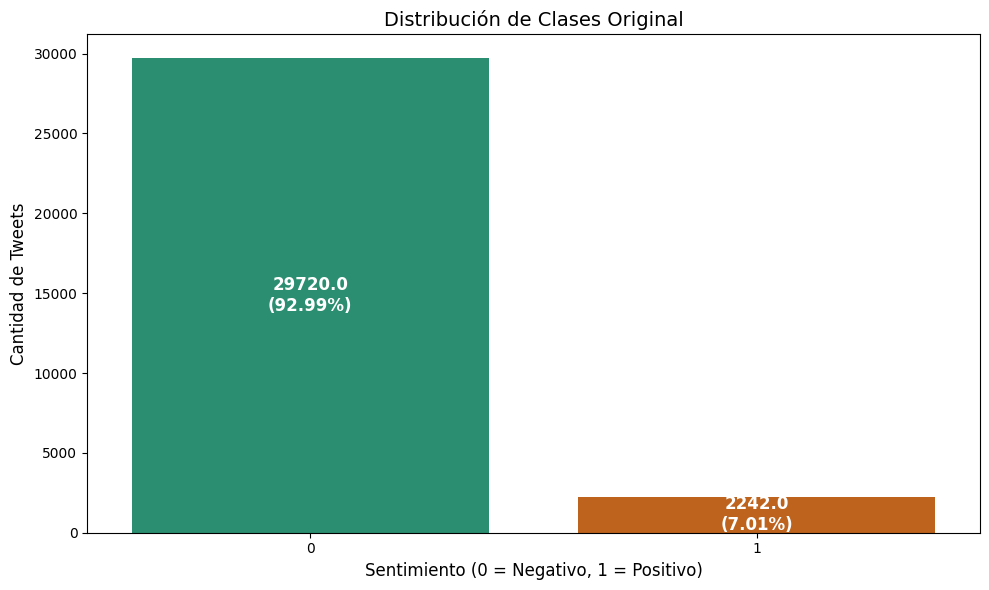

In [9]:
# 1. Importar librerías necesarias
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from src.data_loader import load_data, prepare_data
# get_class_weights
from src.model_bilstm_attention import create_bilstm_attention_model
from src.utils import plot_history, evaluate_model, plot_class_distribution

# 2. Cargar y preparar los datos
print("Cargando y preprocesando datos...")
df = load_data()

# Visualizar distribución de clases
plot_class_distribution(df, title="Distribución de Clases Original")

# Preparar datos para entrenamiento
test_size = 0.2  # 80% entrenamiento, 20% prueba
max_words = 10000
max_len = 100
#X_train, X_test, y_train, y_test, tokenizer = prepare_data(df, max_words=max_words, max_len=max_len, test_size=test_size)

data = prepare_data(
    df,
    max_words=max_words,
    max_len=max_len,
    test_size=test_size,
    balance_method=None  # Ya aplicaste oversampling
)

# Extrae los componentes necesarios
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
tokenizer = data['tokenizer']
vocab_size = data['vocab_size']  # Nuevo valor disponible


In [ ]:
"""
# 2. Carga datos y aplica oversampling en la fase de lectura
from src.data_loader import load_data, prepare_data
from src.utils import plot_class_distribution

# Carga y preprocesa, duplicando la clase minoritaria (label invertido a 1=positivo)
df = load_data(balance_method='oversampling')
plot_class_distribution(df, title="Distribución tras Oversampling")

# 3. Preparar datos SIN SMOTE (ya balanceamos arriba)
X_train, X_test, y_train, y_test, tokenizer = prepare_data(
    df,
    max_words=max_words,
    max_len=max_len,
    test_size=test_size,
    balance_method=None   # ya hicimos oversampling
)
"""

In [10]:
# 3. Definir parámetros del modelo
embedding_dim = 64
lstm_units = 64
dropout_rate = 0.3
batch_size = 128
epochs = 5
validation_split = 0.2
patience = 3
save_dir = 'models'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 4. Crear modelo BiLSTM + Atención
print("Creando modelo BiLSTM + Atención...")
model = create_bilstm_attention_model(vocab_size=max_words, max_len=max_len,
                                      embedding_dim=embedding_dim, 
                                      lstm_units=lstm_units, 
                                      dropout_rate=dropout_rate)

model.summary()

# 5. Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(save_dir, "bilstm_attention_model.h5"),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# 6. Entrenar modelo
print("Entrenando modelo...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Creando modelo BiLSTM + Atención...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ (None, 128)            │           129 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 706,306 (2.69 MB)

 Trainable params: 706,306 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

Entrenando modelo...
Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9132 - loss: 0.2869
Epoch 1: val_loss improved from inf to 0.20768, saving model to models\bilstm_attention_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 86s 435ms/step - accuracy: 0.9133 - loss: 0.2867 - val_accuracy: 0.9299 - val_loss: 0.2077
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9383 - loss: 0.1697
Epoch 2: val_loss improved from 0.20768 to 0.14789, saving model to models\bilstm_attention_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 71s 405ms/step - accuracy: 0.9383 - loss: 0.1697 - val_accuracy: 0.9499 - val_loss: 0.1479
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9659 - loss: 0.0997
Epoch 3: val_loss improved from 0.14789 to 0.12786, saving model to models\bilstm_attention_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 403ms/step - accuracy: 0.9659 - loss: 0.0996 - val_accuracy: 0.9562 - val_loss: 0.1279
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9788 - loss: 0.0712
Epoch 4: val_loss did not improve from 0.12786
175/175 ━━━━━━━━━━━━━━━━━━━━ 71s 405ms/step - accuracy: 0.9788 - loss: 0.0713 - val_accuracy: 0.9579 - val_loss: 0.1344
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9818 - loss: 0.0590
Epoch 5: val_loss did not improve from 0.12786
175/175 ━━━━━━━━━━━━━━━━━━━━ 71s 408ms/step - accuracy: 0.9818 - loss: 0.0589 - val_accuracy: 0.9571 - val_loss: 0.1486


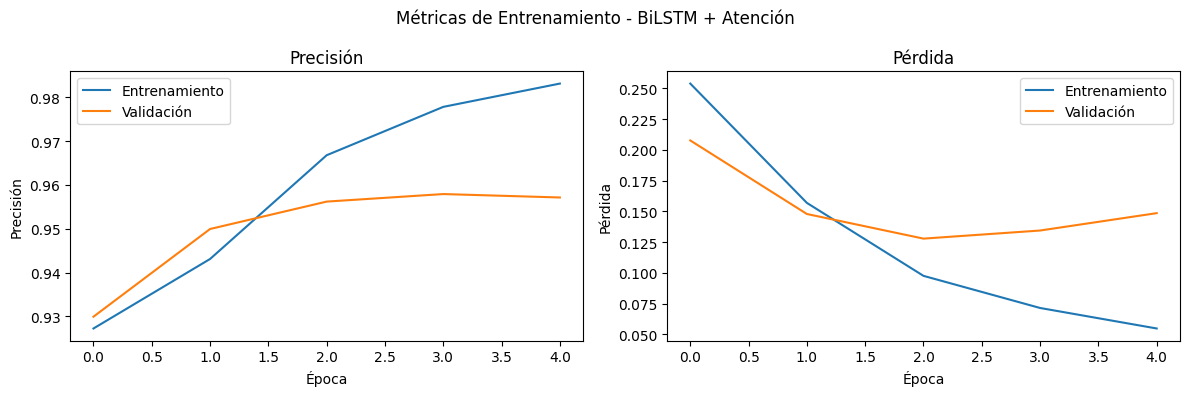


Evaluando desempeño del modelo...
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step
Accuracy: 0.9562
Precision: 0.7561
Recall: 0.5536
F1-score: 0.6392


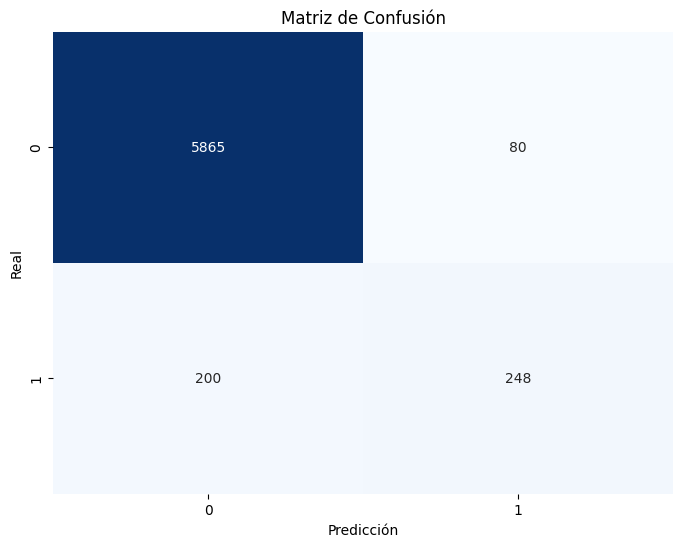

In [11]:
# 7. Visualizar métricas de entrenamiento
plot_history(history, title="Métricas de Entrenamiento - BiLSTM + Atención")

# 8. Evaluar modelo
print("\nEvaluando desempeño del modelo...")
metrics = evaluate_model(model, X_test, y_test)



# 9. Guardar tokenizer y modelo

In [12]:
# Crear directorio para modelos si no existe
os.makedirs('../models', exist_ok=True)

# 9. Guardar tokenizer
tokenizer_json = tokenizer.to_json()
tokenizer_path = os.path.join(save_dir, "bilstm_attention_tokenizer.json")
with open(tokenizer_path, 'w') as f:
    f.write(tokenizer_json)

print(f"Tokenizer guardado en: {tokenizer_path}")

# Guardar modelo
model_path = '../models/bilstm_attention_model.h5'
model.save(model_path)
print(f"Modelo guardado en: {model_path}")

Tokenizer guardado en: models\bilstm_attention_tokenizer.json
Modelo guardado en: ../models/bilstm_attention_model.h5


In [13]:
# 10. Mostrar métricas finales
print("\nMétricas finales:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Métricas finales:
accuracy: 0.9562
precision: 0.7561
recall: 0.5536
f1: 0.6392
